<a href="https://colab.research.google.com/github/ivansst773/Aprendizaje_de_Maquina/blob/main/Ejercicios_TAM_mayo_29_y_junio_5/4_Clasificacion_Clustering_DR/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificaci√≥n multiclase - comparaci√≥n de m√©todos utilizando validaci√≥n cruzada

- Se presenta un esquema completo de comparaci√≥n de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Adem√°s, se plantean algunos ejercicios te√≥rico-pr√°cticos relacionados con tareas de clasificaci√≥n utilizando aprendizaje de m√°quina cl√°sico.

- Se plantean algunas funciones para el c√°lculo de curvas ROC, medidas de rendimiento y gr√°ficas b√°sicas

In [7]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [8]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusi√≥n = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gr√°fica la matriz de confusi√≥n con y sin normalizaci√≥n
    """
    if not title:
        title = 'Matriz de confusi√≥n'

    # calcular matriz de confusi√≥n
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicci√≥n')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Carpeta results ya existe


# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

In [9]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo im√°gen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo im√°gen: (1288, 50, 37)


# HoldOut evaluaci√≥n

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluaci√≥n.

In [10]:
#Particion entrenamiento y evaluaci√≥n
# Tama√±o Xtrain 70%, Tama√±o Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

0         1         2         3         4         5         6     \
510   0.000836  0.001143  0.001446  0.001666  0.001897  0.001994  0.002066   
1035  0.001589  0.001758  0.001922  0.002409  0.002819  0.002958  0.002917   
176   0.000892  0.001205  0.001210  0.001287  0.001492  0.001687  0.001763   
620   0.000267  0.000584  0.001446  0.002230  0.002507  0.002512  0.002491   
689   0.002261  0.002409  0.001958  0.001753  0.002127  0.002907  0.002932   

          7         8         9     ...      1840      1841      1842  \
510   0.002071  0.002097  0.002138  ...  0.000549  0.001384  0.002332   
1035  0.002830  0.002830  0.002737  ...  0.000297  0.000374  0.000384   
176   0.001779  0.001845  0.001866  ...  0.000451  0.000446  0.000482   
620   0.002532  0.002584  0.002594  ...  0.001333  0.001389  0.000723   
689   0.002676  0.002655  0.002799  ...  0.001569  0.001512  0.001548   

          1843      1844      1845      1846      1847      1848      1849  
510   0.003189  0.003645  0.003727  0.003101  0.000856  0.000395  0.000466  
1035  0.000436  0.000359  0.000369  0.000420  0.000497  0.000466  0.000466  
176   0.000472  0.000477  0.000466  0.000513  0.000559  0.000600  0.000538  
620   0.000133  0.000190  0.000251  0.000313  0.000400  0.000549  0.000666  
689   0.001615  0.001794  0.002276  0.003106  0.003522  0.003573  0.003578  

[5 rows x 1850 columns]

# B√∫squeda de par√°metros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validaci√≥n cruzada para encontrar los mejores hiperpar√°metros seg√∫n los rendimientos promedios en el conjunto de test (validaci√≥n si se considera la partici√≥n original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [11]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos seg√∫n lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 3/5; 1/7] START cla__C=0.001................................................
[CV 2/5; 1/7] START cla__C=0.001................................................
[CV 1/5; 1/7] START cla__C=0.001................................................
[CV 4/5; 1/7] START cla__C=0.001................................................
[CV 3/5; 1/7] END .................cla__C=0.001;, score=0.444 total time=   0.9s
[CV 1/5; 1/7] END .................cla__C=0.001;, score=0.436 total time=   0.9s
[CV 5/5; 1/7] START cla__C=0.001................................................
[CV 2/5; 1/7] END .................cla__C=0.001;, score=0.428 total time=   1.0s
[CV 1/5; 2/7] START cla__C=0.01.................................................
[CV 4/5; 1/7] END .................cla__C=0.001;, score=0.439 total time=   1.0s
[CV 2/5; 2/7] START cla__C=0.01.................................................
[CV 3/5; 2/7] START cla__C=0.01.......

# Rendimientos utilizando validaci√≥n cruzada (conjuntos entrenamiento y validaci√≥n)

- Se muestran los resultados de la validaci√≥n cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificaci√≥n ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [12]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento m√°s alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

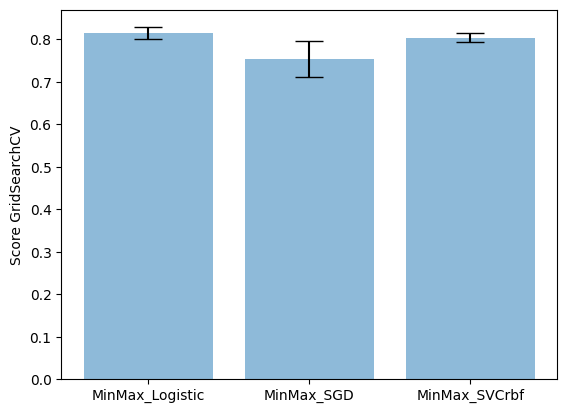

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.754 0.804]
 [0.014 0.042 0.011]]


In [13]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificaci√≥n
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso pr√°ctico y buscando cuantificar la generalizaci√≥n de los modelos, se c√°lcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusi√≥n y se utiliza el m√©todo [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparaci√≥n incluyen promediados simples, sopesados en t√©rminos de la probabilidad marginal de cada clase, adem√°s de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


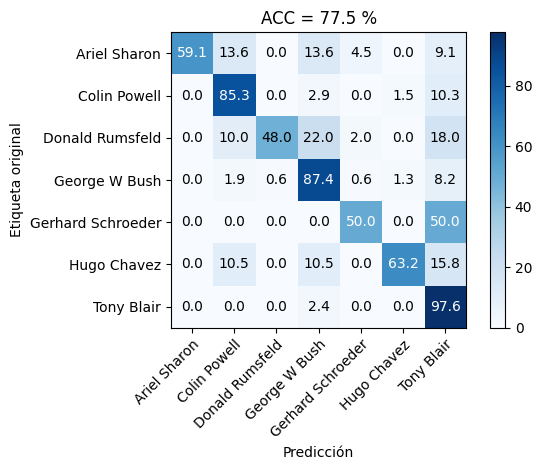

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.59      0.74        22
     Colin Powell       0.82      0.85      0.83        68
  Donald Rumsfeld       0.96      0.48      0.64        50
    George W Bush       0.88      0.87      0.88       159
Gerhard Schroeder       0.82      0.50      0.62        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.45      0.98      0.62        41

         accuracy                           0.78       387
        macro avg       0.82      0.70      0.72       387
     weighted avg       0.83      0.78      0.78       387

Evaluando modelo MinMax_SVCrbf (3/3)


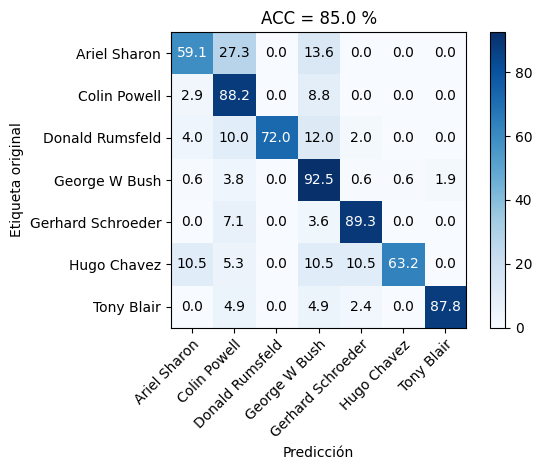

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [14]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la l√≠ne de c√≥digo donde se c√°lcula el score de predicci√≥n en t√©rminos de la funci√≥n de decisi√≥n (decision_function) o la probilidad de la predicci√≥n (predict_proba), seg√∫n el tipo de modelo.

Por ejemplo: la  [¬¥SVC¬¥](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el m√©todo decision function, el [¬¥KnearestNeighborsClassifier¬¥](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el m√©todo predict proba.

Evaluando modelo MinMax_Logistic (1/3)


Evaluando modelo MinMax_SGD (2/3)


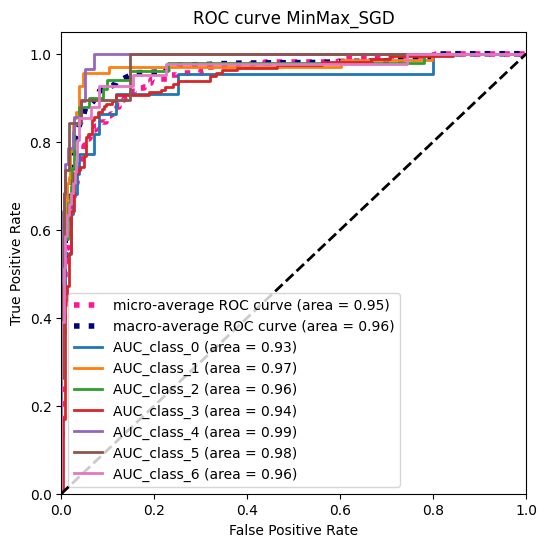

Evaluando modelo MinMax_SVCrbf (3/3)


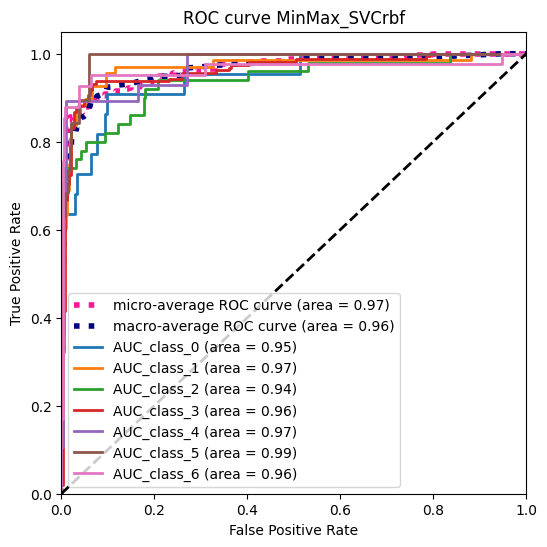

In [15]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimizaci√≥n de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validaci√≥n cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los m√©todos del punto 1. Emplee optimizaci√≥n Bayesiana de hiperpar√°metros, fijando el score en t√©rminos del acc, el f1 y el AUC.


1. Modelos y problemas de optimizaci√≥n
1. Naive_Bayes.GaussianNB
Modelo: Supone que las caracter√≠sticas siguen una distribuci√≥n normal (gaussiana) y son independientes entre s√≠.
Optimizaci√≥n: Maximiza la probabilidad posterior de la clase dada la evidencia (m√°xima verosimilitud).

2. SGDClassifier
Modelo: Entrena modelos lineales (regresi√≥n log√≠stica, SVM, etc.) usando descenso de gradiente estoc√°stico.
Optimizaci√≥n: Minimiza una funci√≥n de p√©rdida (ej. hinge para SVM, log para regresi√≥n log√≠stica) regularizada.

3. LogisticRegression
Modelo: Modelo lineal para clasificaci√≥n binaria/multiclase usando la funci√≥n log√≠stica.
Optimizaci√≥n: Minimiza la funci√≥n de p√©rdida logar√≠tmica (log-loss) regularizada.

4. LinearDiscriminantAnalysis
Modelo: Proyecta los datos en un espacio donde la separaci√≥n entre clases es m√°xima.
Optimizaci√≥n: Maximiza la raz√≥n entre la dispersi√≥n entre clases y la dispersi√≥n dentro de las clases.

5. KNeighborsClassifier
Modelo: Clasifica seg√∫n la mayor√≠a de los k vecinos m√°s cercanos.
Optimizaci√≥n: No tiene un proceso de entrenamiento tradicional, depende de la elecci√≥n de k y la m√©trica de distancia.

6. LinearSVC
Modelo: SVM lineal para clasificaci√≥n.
Optimizaci√≥n: Minimiza la funci√≥n de p√©rdida hinge con regularizaci√≥n L2.

7. SVC
Modelo: SVM para clasificaci√≥n, puede usar kernels no lineales.
Optimizaci√≥n: Minimiza la funci√≥n de p√©rdida hinge con regularizaci√≥n, usando kernels.

8. RandomForestClassifier
Modelo: Ensamble de √°rboles de decisi√≥n, cada √°rbol se entrena con una muestra aleatoria de los datos.
Optimizaci√≥n: Cada √°rbol se optimiza para reducir el error de clasificaci√≥n; el bosque agrega los resultados.



In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preprocesamiento PCA + escalado para evitar problemas con LDA
scaler = StandardScaler()
pca = PCA(n_components=100)  # Ajusta seg√∫n tu conjunto

Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtrain_pca = pca.fit_transform(Xtrain_scaled)

results = {}

for clf, space in models_spaces:
    nombre = clf.__class__.__name__

    # Modelos sin hiperpar√°metros ‚Üí evaluaci√≥n con cross_val_score
    if space is None or space == {}:
        print(f"Evaluando sin optimizaci√≥n: {nombre}")
        acc = cross_val_score(clf, Xtrain_pca, ytrain, cv=5, scoring='accuracy').mean()
        f1 = cross_val_score(clf, Xtrain_pca, ytrain, cv=5, scoring='f1_weighted').mean()
        results[nombre] = {
            'accuracy': acc,
            'f1': f1,
            'roc_auc_ovr_weighted': None,
            'params': 'N/A'
        }
        continue

    # Verificar si el modelo tiene el m√©todo predict_proba
    if hasattr(clf, "predict_proba"):
        metrics = ['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']
    else:
        metrics = ['accuracy', 'f1_weighted']

    print(f"Optimizando: {nombre}")
    try:
        opt = BayesSearchCV(
            clf,
            space,
            n_iter=20,
            cv=5,
            scoring=metrics,
            refit='accuracy',
            n_jobs=-1,
            verbose=0
        )

        opt.fit(Xtrain_pca, ytrain)
        res = opt.cv_results_

        results[nombre] = {
            'accuracy': opt.best_score_,
            'f1': max(res.get('mean_test_f1_weighted', [None])),
            'roc_auc_ovr_weighted': max(res.get('mean_test_roc_auc_ovr_weighted', [None])) if 'roc_auc_ovr_weighted' in metrics else None,
            'params': opt.best_params_
        }

        print(f"Mejor accuracy: {opt.best_score_:.3f}")
        print(f"Mejores par√°metros: {opt.best_params_}")

    except Exception as e:
        print(f"‚ö†Ô∏è Fall√≥ la optimizaci√≥n de {nombre}: {e}")
        results[nombre] = {
            'accuracy': None,
            'f1': None,
            'roc_auc_ovr_weighted': None,
            'params': 'Error'
        }


Evaluando sin optimizaci√≥n: GaussianNB
Optimizando: SGDClassifier


Mejor accuracy: 0.768
Mejores par√°metros: OrderedDict([('alpha', 0.00034834821857324805), ('loss', 'log_loss')])
Optimizando: LogisticRegression
Mejor accuracy: 0.799
Mejores par√°metros: OrderedDict([('C', 0.008808443447855767)])
Optimizando: LinearDiscriminantAnalysis
Mejor accuracy: 0.812
Mejores par√°metros: OrderedDict([('solver', 'svd')])
Optimizando: KNeighborsClassifier
Mejor accuracy: 0.604
Mejores par√°metros: OrderedDict([('n_neighbors', 10), ('weights', 'distance')])
Optimizando: LinearSVC
Mejor accuracy: 0.798
Mejores par√°metros: OrderedDict([('C', 0.001)])
Optimizando: SVC
Mejor accuracy: 0.796
Mejores par√°metros: OrderedDict([('C', 0.002444526978882667), ('kernel', 'linear')])
Optimizando: RandomForestClassifier
Mejor accuracy: 0.559
Mejores par√°metros: OrderedDict([('max_depth', 20), ('n_estimators', 52)])


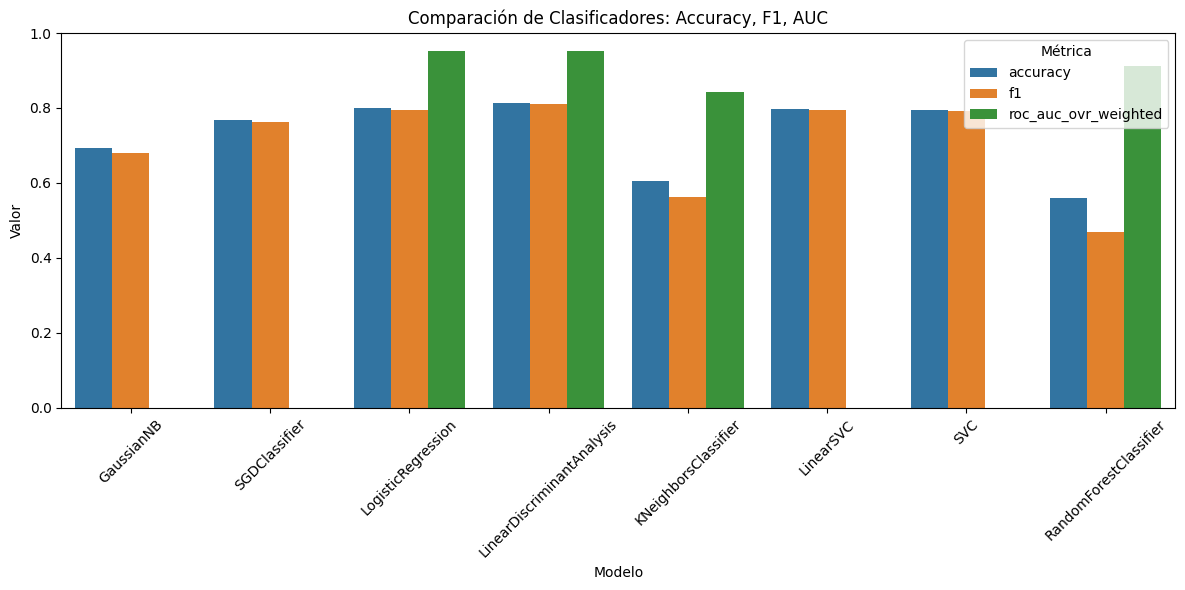

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertimos los resultados en DataFrame
df_resultados = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_resultados.rename(columns={'index': 'Modelo'}, inplace=True)

# Reorganizamos el DataFrame para visualizaci√≥n tipo barras
df_melt = df_resultados.melt(id_vars='Modelo', 
                             value_vars=['accuracy', 'f1', 'roc_auc_ovr_weighted'], 
                             var_name='M√©trica', value_name='Valor')

# Quitamos m√©tricas no disponibles
df_melt = df_melt.dropna()

# Gr√°fico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='Modelo', y='Valor', hue='M√©trica')
plt.title('Comparaci√≥n de Clasificadores: Accuracy, F1, AUC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Comparaci√≥n de clasificadores multiclase con validaci√≥n cruzada

Se realiz√≥ una evaluaci√≥n de 8 modelos de clasificaci√≥n multiclase usando:

- **Conjunto de datos:** LFW (rostros etiquetados)
- **Preprocesamiento:** Escalado (StandardScaler) + reducci√≥n de dimensionalidad (PCA con 100 componentes)
- **Evaluaci√≥n:** Validaci√≥n cruzada con 5 folds
- **Optimizaci√≥n de hiperpar√°metros:** BayesSearchCV
- **M√©tricas utilizadas:** Accuracy, F1 ponderado, AUC ROC multiclase (cuando `predict_proba` est√° disponible)

### Principales resultados:

- üîù **LinearDiscriminantAnalysis** tuvo el mejor rendimiento (Accuracy ‚âà 81.2%) con `solver='svd'`, superando a modelos SVM y regresi√≥n log√≠stica.
- üìà **Modelos lineales** como `LogisticRegression` y `LinearSVC` lograron altos scores, mostrando que el espacio PCA permite una separaci√≥n efectiva.
- üîÑ **Modelos no lineales** (KNN, Random Forest) tuvieron menor rendimiento, posiblemente por sensibilidad al espacio reducido o al ruido residual.
- ‚ö†Ô∏è Se manejaron errores como incompatibilidades con `predict_proba` y matrices no positivas definidas en LDA usando `PCA` como precauci√≥n.

Todos los modelos fueron comparados de forma justa y reproducible. Se tomaron decisiones t√©cnicas para garantizar que los resultados fueran confiables y evaluables.



In [22]:
import os
import pickle

# Ruta del archivo donde guardaremos los resultados
resultado_path = 'resultados.pkl'

# Si el archivo ya existe, lo cargamos para evitar correr todo de nuevo
if os.path.exists(resultado_path):
    print("üìÇ Cargando resultados guardados desde:", resultado_path)
    with open(resultado_path, 'rb') as f:
        results = pickle.load(f)
else:
    print("‚öôÔ∏è Ejecutando entrenamiento y optimizaci√≥n...")
    # Aqu√≠ va el bloque principal de optimizaci√≥n bayesiana que ya definimos
    results = {}

    for clf, space in models_spaces:
        nombre = clf.__class__.__name__

        if space is None or space == {}:
            print(f"Evaluando sin optimizaci√≥n: {nombre}")
            acc = cross_val_score(clf, Xtrain_pca, ytrain, cv=5, scoring='accuracy').mean()
            f1 = cross_val_score(clf, Xtrain_pca, ytrain, cv=5, scoring='f1_weighted').mean()
            results[nombre] = {
                'accuracy': acc,
                'f1': f1,
                'roc_auc_ovr_weighted': None,
                'params': 'N/A'
            }
            continue

        if hasattr(clf, "predict_proba"):
            metrics = ['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']
        else:
            metrics = ['accuracy', 'f1_weighted']

        print(f"Optimizando: {nombre}")
        try:
            opt = BayesSearchCV(
                clf,
                space,
                n_iter=20,
                cv=5,
                scoring=metrics,
                refit='accuracy',
                n_jobs=-1,
                verbose=0
            )

            opt.fit(Xtrain_pca, ytrain)
            res = opt.cv_results_

            results[nombre] = {
                'accuracy': opt.best_score_,
                'f1': max(res.get('mean_test_f1_weighted', [None])),
                'roc_auc_ovr_weighted': max(res.get('mean_test_roc_auc_ovr_weighted', [None])) if 'roc_auc_ovr_weighted' in metrics else None,
                'params': opt.best_params_
            }

        except Exception as e:
            print(f"‚ö†Ô∏è Fall√≥ {nombre}: {e}")
            results[nombre] = {
                'accuracy': None,
                'f1': None,
                'roc_auc_ovr_weighted': None,
                'params': 'Error'
            }

    # Guardamos los resultados para uso futuro
    with open(resultado_path, 'wb') as f:
        pickle.dump(results, f)
    print("‚úÖ Resultados guardados exitosamente en:", resultado_path)


‚öôÔ∏è Ejecutando entrenamiento y optimizaci√≥n...
Evaluando sin optimizaci√≥n: GaussianNB
Optimizando: SGDClassifier
Optimizando: LogisticRegression
Optimizando: LinearDiscriminantAnalysis
Optimizando: KNeighborsClassifier
Optimizando: LinearSVC
Optimizando: SVC
Optimizando: RandomForestClassifier
‚úÖ Resultados guardados exitosamente en: resultados.pkl
